In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
from PIL import Image 


import numpy as np 
import math 
import copy 
from IPython.core.debugger import set_trace

import skimage.io as io 

In [2]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Dropout, Activation, Lambda, Permute, Reshape, Add, add
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Deconvolution2D, Cropping2D
from keras.layers import merge

Using TensorFlow backend.
c:\users\camng3\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\camng3\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\camng3\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.in

# Build model architecture

# FCN  for Semantic Segmentation

As backbone VGG16 is used

# Combining what and where

We define a new fully convolutional net (FCN) for segmentation that combines layers of the feature hierarchy and refines the spatial precision of the output. While fully convolutionalized classifiers can be fine-tuned to segmentation as shown in 4.1, and even score highly on the standard metric, their output is dissatisfyingly coarse. The 32 pixel stride at the final prediction layer limits the scale of detail in the upsampled output.

We address this by adding skips that combine the final prediction layer with lower layers with finer strides. This turns a line topology into a DAG [code comment : this is why some latter stage layers have 2 inputs], with edges that skip ahead from lower layers to higher ones. As they see fewer pixels, the finer scale predictions should need fewer layers, so it makes sense to make them from shallower net outputs. Combining fine layers and coarse layers lets the model make local predictions that respect global structure.

We first divide the output stride in half by predicting from a 16 pixel stride layer. We add a 1x1 convolution layer on top of pool4 [code comment : the score_pool4_filter layer] to produce additional class predictions. We fuse this output with the predictions computed on top of conv7 (convolutionalized fc7) at stride 32 by adding a 2x upsampling layer and summing [code comment : layer named sum] both predictions [code warning : requires first layer crop to insure the same size].

Finally, the stride 16 predictions are upsampled back to the image [code comment : layer named upsample_new].

We call this net FCN-16s.

<b>Remark

<b>The original paper mention that FCN-8s (slightly more complex architecture) does not provide much improvement so we stopped at FCN-16s

In [3]:
image_size = 512

In [4]:
def convblock(cdim, nb, bits=3):
    L = []

    for k in range(1, bits + 1):
        convname = 'conv' + str(nb) + '_' + str(k)
        if False:
                # first version I tried
            L.append(ZeroPadding2D((1, 1)))
            L.append(Convolution2D(cdim, kernel_size=(3, 3), activation='relu', name=convname))
        else:
            L.append(Convolution2D(cdim, kernel_size=(3, 3), padding='same', activation='relu', name=convname))

    L.append(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    return L

In [5]:
def fcn_32(image_size):
    withDO = False  # no effect during evaluation but usefull for fine-tuning
    if True:
        mdl = Sequential()

        # First layer is a dummy-permutation = Identity to specify input shape
        mdl.add(Permute((1, 2, 3), input_shape=(image_size, image_size, 3)))  # WARNING : axis 0 is the sample dim

        for l in convblock(64, 1, bits=2):
            mdl.add(l)

        for l in convblock(128, 2, bits=2):
            mdl.add(l)

        for l in convblock(256, 3, bits=3):
            mdl.add(l)

        for l in convblock(512, 4, bits=3):
            mdl.add(l)

        for l in convblock(512, 5, bits=3):
            mdl.add(l)

        mdl.add(Convolution2D(4096, kernel_size=(7, 7), padding='same', activation='relu', name='fc6'))  # WARNING border
        if withDO:
            mdl.add(Dropout(0.5))
        mdl.add(Convolution2D(4096, kernel_size=(1, 1), padding='same', activation='relu', name='fc7'))  # WARNING border
        if withDO:
            mdl.add(Dropout(0.5))

        # WARNING : model decapitation i.e. remove the classifier step of VGG16 (usually named fc8)

        mdl.add(Convolution2D(21, kernel_size=(1, 1), padding='same', activation='relu', name='score_fr'))
        
        convsize = mdl.layers[-1].output_shape[2]
        deconv_output_size = (convsize - 1) * 2 + 4  # INFO: =34 when images are 512x512
        # WARNING : valid, same or full ?
        mdl.add(Deconvolution2D(21, kernel_size=(4, 4), strides=(2, 2), padding='valid', activation=None, name='score2'))

        extra_margin = deconv_output_size - convsize * 2  # INFO: =2 when images are 512x512
        assert (extra_margin > 0)
        assert (extra_margin % 2 == 0)
        # INFO : cropping as deconv gained pixels
        # print(extra_margin)
        c = ((0, extra_margin), (0, extra_margin))
        # print(c)
        mdl.add(Cropping2D(cropping=c))
        # print(mdl.summary())

        return mdl

    else:
        # See following link for a version based on Keras functional API :
        # gist.github.com/EncodeTS/6bbe8cb8bebad7a672f0d872561782d9
        raise ValueError('not implemented')

In [6]:
def fcn_32s_to_16s(fcn32model=None):
    if fcn32model is None:
        fcn32model = fcn32_blank()

    fcn32shape = fcn32model.layers[-1].output_shape
    assert (len(fcn32shape) == 4)
    assert (fcn32shape[0] is None)  # batch axis
    assert (fcn32shape[3] == 21)  # number of filters
    assert (fcn32shape[1] == fcn32shape[2])  # must be square

    fcn32size = fcn32shape[1]  # INFO: =32 when images are 512x512

    if fcn32size != 32:
        print('WARNING : handling of image size different from 512x512 has not been tested')

    sp4 = Convolution2D(21, kernel_size=(1, 1), padding='same', activation=None, name='score_pool4')

    # INFO : to replicate MatConvNet.DAGN.Sum layer see documentation at :
    # https://keras.io/getting-started/sequential-model-guide/
    summed = add(inputs=[sp4(fcn32model.layers[14].output), fcn32model.layers[-1].output])

    # INFO :
    # final 16x16 upsampling of "summed" using deconv layer upsample_new (32, 32, 21, 21)
    # deconv setting is valid if (528-32)/16 + 1 = deconv_input_dim (= fcn32size)
    deconv_output_size = (fcn32size - 1) * 16 + 32  # INFO: =528 when images are 512x512
    upnew = Deconvolution2D(21, kernel_size=(32, 32),
                            padding='valid',  # WARNING : valid, same or full ?
                            strides=(16, 16),
                            activation=None,
                            name='upsample_new')

    extra_margin = deconv_output_size - fcn32size * 16  # INFO: =16 when images are 512x512
    assert (extra_margin > 0)
    assert (extra_margin % 2 == 0)
    # print(extra_margin)
    # INFO : cropping as deconv gained pixels
    crop_margin = Cropping2D(cropping=((0, extra_margin), (0, extra_margin)))
    return Model(fcn32model.input, crop_margin(upnew(summed)))


In [7]:
def prediction(kmodel, crpimg, transform=False):
    # INFO : crpimg should be a cropped image of the right dimension

    # transform=True seems more robust but I think the RGB channels are not in right order

    imarr = np.array(crpimg).astype(np.float32)

    if transform:
        imarr[:, :, 0] -= 129.1863
        imarr[:, :, 1] -= 104.7624
        imarr[:, :, 2] -= 93.5940
        #
        # WARNING : in this script (https://github.com/rcmalli/keras-vggface) colours are switched
        aux = copy.copy(imarr)
        imarr[:, :, 0] = aux[:, :, 2]
        imarr[:, :, 2] = aux[:, :, 0]

    imarr = np.expand_dims(imarr, axis=0)

    return kmodel.predict(imarr)

In [8]:
fcn32model = fcn_32(image_size)

W0522 15:05:31.189230 42400 deprecation_wrapper.py:119] From c:\users\camng3\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0522 15:05:31.215226 42400 deprecation_wrapper.py:119] From c:\users\camng3\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:519: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0522 15:05:31.219232 42400 deprecation_wrapper.py:119] From c:\users\camng3\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:4140: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0522 15:05:31.254226 42400 deprecation_wrapper.py:119] From c:\users\camng3\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:3978: The name tf.nn.max_pool is deprecate

In [9]:
fcn32model.layers[-1].input_shape

(None, 34, 34, 21)

In [10]:
fcn32model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_1 (Permute)          (None, 512, 512, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 512, 512, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 512, 512, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 256, 256, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 256, 256, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 256, 256, 128)     147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 128, 128, 128)     0         
__________

In [11]:
fcn16model = fcn_32s_to_16s(fcn32model)


In [12]:
fcn16model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
permute_1_input (InputLayer)    (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
permute_1 (Permute)             (None, 512, 512, 3)  0           permute_1_input[0][0]            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 512, 512, 64) 1792        permute_1[0][0]                  
__________________________________________________________________________________________________
conv1_2 (Conv2D)                (None, 512, 512, 64) 36928       conv1_1[0][0]                    
__________________________________________________________________________________________________
max_poolin

# Load VGG weigths and FCN16 from .mat file¶


In [13]:
from scipy.io import loadmat


In [14]:
data = loadmat('pascal-fcn16s-dag.mat', matlab_compatible=False, struct_as_record=False)
l = data['layers']
p = data['params']
description = data['meta'][0,0].classes[0,0].description

In [15]:
description

array([[array(['background'], dtype='<U10'),
        array(['aeroplane'], dtype='<U9'),
        array(['bicycle'], dtype='<U7'), array(['bird'], dtype='<U4'),
        array(['boat'], dtype='<U4'), array(['bottle'], dtype='<U6'),
        array(['bus'], dtype='<U3'), array(['car'], dtype='<U3'),
        array(['cat'], dtype='<U3'), array(['chair'], dtype='<U5'),
        array(['cow'], dtype='<U3'),
        array(['diningtable'], dtype='<U11'),
        array(['dog'], dtype='<U3'), array(['horse'], dtype='<U5'),
        array(['motorbike'], dtype='<U9'),
        array(['person'], dtype='<U6'),
        array(['pottedplant'], dtype='<U11'),
        array(['sheep'], dtype='<U5'), array(['sofa'], dtype='<U4'),
        array(['train'], dtype='<U5'), array(['tvmonitor'], dtype='<U9')]],
      dtype=object)

In [16]:
for i in range(l.shape[1]):
    print(i,
          str(l[0,i].name[0]), str(l[0,i].type[0]),
          [str(n[0]) for n in l[0,i].inputs[0,:]],
          [str(n[0]) for n in l[0,i].outputs[0,:]])

0 conv1_1 dagnn.Conv ['data'] ['conv1_1']
1 relu1_1 dagnn.ReLU ['conv1_1'] ['conv1_1x']
2 conv1_2 dagnn.Conv ['conv1_1x'] ['conv1_2']
3 relu1_2 dagnn.ReLU ['conv1_2'] ['conv1_2x']
4 pool1 dagnn.Pooling ['conv1_2x'] ['pool1']
5 conv2_1 dagnn.Conv ['pool1'] ['conv2_1']
6 relu2_1 dagnn.ReLU ['conv2_1'] ['conv2_1x']
7 conv2_2 dagnn.Conv ['conv2_1x'] ['conv2_2']
8 relu2_2 dagnn.ReLU ['conv2_2'] ['conv2_2x']
9 pool2 dagnn.Pooling ['conv2_2x'] ['pool2']
10 conv3_1 dagnn.Conv ['pool2'] ['conv3_1']
11 relu3_1 dagnn.ReLU ['conv3_1'] ['conv3_1x']
12 conv3_2 dagnn.Conv ['conv3_1x'] ['conv3_2']
13 relu3_2 dagnn.ReLU ['conv3_2'] ['conv3_2x']
14 conv3_3 dagnn.Conv ['conv3_2x'] ['conv3_3']
15 relu3_3 dagnn.ReLU ['conv3_3'] ['conv3_3x']
16 pool3 dagnn.Pooling ['conv3_3x'] ['pool3']
17 conv4_1 dagnn.Conv ['pool3'] ['conv4_1']
18 relu4_1 dagnn.ReLU ['conv4_1'] ['conv4_1x']
19 conv4_2 dagnn.Conv ['conv4_1x'] ['conv4_2']
20 relu4_2 dagnn.ReLU ['conv4_2'] ['conv4_2x']
21 conv4_3 dagnn.Conv ['conv4_2x'] ['co

In [107]:
def copy_mat_to_keras(kmodel):
    
    kerasnames = [lr.name for lr in kmodel.layers]

    prmt = (0, 1, 2, 3) # WARNING : important setting as 2 of the 4 axis have same size dimension
    
    for i in range(0, p.shape[1]-1, 2):
        matname = '_'.join(p[0,i].name[0].split('_')[0:-1])
        if matname in kerasnames:
            kindex = kerasnames.index(matname)
            print('found : ', (str(matname), kindex))
            l_weights = p[0,i].value
            l_bias = p[0,i+1].value
            f_l_weights = l_weights.transpose(prmt)
            if False: # WARNING : this depends on "image_data_format":"channels_last" in keras.json file
                f_l_weights = np.flip(f_l_weights, 0)
                f_l_weights = np.flip(f_l_weights, 1)
            print(f_l_weights.shape, kmodel.layers[kindex].get_weights()[0].shape)
            assert (f_l_weights.shape == kmodel.layers[kindex].get_weights()[0].shape)
            assert (l_bias.shape[1] == 1)
            assert (l_bias[:,0].shape == kmodel.layers[kindex].get_weights()[1].shape)
            assert (len(kmodel.layers[kindex].get_weights()) == 2)
            kmodel.layers[kindex].set_weights([f_l_weights, l_bias[:,0]])
        else:
            print('not found : ', str(matname))

In [108]:
copy_mat_to_keras(fcn16model)

found :  ('conv1_1', 2)
(3, 3, 3, 64) (3, 3, 3, 64)
found :  ('conv1_2', 3)
(3, 3, 64, 64) (3, 3, 64, 64)
found :  ('conv2_1', 5)
(3, 3, 64, 128) (3, 3, 64, 128)
found :  ('conv2_2', 6)
(3, 3, 128, 128) (3, 3, 128, 128)
found :  ('conv3_1', 8)
(3, 3, 128, 256) (3, 3, 128, 256)
found :  ('conv3_2', 9)
(3, 3, 256, 256) (3, 3, 256, 256)
found :  ('conv3_3', 10)
(3, 3, 256, 256) (3, 3, 256, 256)
found :  ('conv4_1', 12)
(3, 3, 256, 512) (3, 3, 256, 512)
found :  ('conv4_2', 13)
(3, 3, 512, 512) (3, 3, 512, 512)
found :  ('conv4_3', 14)
(3, 3, 512, 512) (3, 3, 512, 512)
found :  ('conv5_1', 16)
(3, 3, 512, 512) (3, 3, 512, 512)
found :  ('conv5_2', 17)
(3, 3, 512, 512) (3, 3, 512, 512)
found :  ('conv5_3', 18)
(3, 3, 512, 512) (3, 3, 512, 512)
found :  ('fc6', 20)
(7, 7, 512, 4096) (7, 7, 512, 4096)
found :  ('fc7', 21)
(1, 1, 4096, 4096) (1, 1, 4096, 4096)
found :  ('score_fr', 22)
(1, 1, 4096, 21) (1, 1, 4096, 21)
found :  ('score2', 23)
(4, 4, 21, 21) (4, 4, 21, 21)
found :  ('score_pool

In [109]:
im = Image.open('rgb.jpg') # http://www.robots.ox.ac.uk/~szheng/crfasrnndemo/static/rgb.jpg
im = im.crop((0,0,319,319)) # WARNING : manual square cropping
im = im.resize((image_size,image_size))

(512, 512, 3)


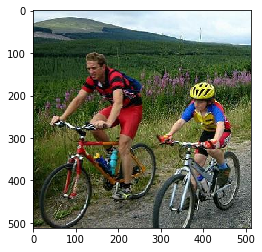

In [110]:
plt.imshow(np.asarray(im))
print(np.asarray(im).shape)

In [111]:
crpim = im # WARNING : we deal with cropping in a latter section, this image is already fit
preds = prediction(fcn16model, crpim, transform=False) # WARNING : transfrom=True requires a code change (dim order)


In [112]:
class2index = {}

for i, clname in enumerate(description[0,:]):
    class2index[str(clname[0])] = i
    
print(sorted(class2index.keys()))

['aeroplane', 'background', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


In [ ]:
#original preds (1,512,512,21)

# imclass = np.argmax(preds, axis=3)[0,:,:] will return 512,512 with values from 0 to 20 where 
# these values represent the class

# will take from the all 21 dimension the pixes with the highest value  

In [153]:
imclass = np.argmax(preds, axis=3)[0,:,:]
imclass[400] # row 400 is assigned to class 2 , namely bike 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [152]:
imclass_1 = preds[0][:,:,2]

array([ 0.08373128,  0.25119385,  0.4186564 ,  0.58611894,  0.7535816 ,
        0.9210441 ,  1.0885067 ,  1.2559693 ,  1.4234318 ,  1.5908943 ,
        1.7583569 ,  1.9258195 ,  2.093282  ,  2.2607446 ,  2.4282074 ,
        2.5956697 ,  2.8224242 ,  3.1084704 ,  3.3945165 ,  3.6805625 ,
        3.966609  ,  4.252655  ,  4.538701  ,  4.8247476 ,  5.1107936 ,
        5.39684   ,  5.682886  ,  5.9689326 ,  6.254978  ,  6.5410247 ,
        6.8270707 ,  7.113117  ,  7.3576865 ,  7.5607786 ,  7.7638717 ,
        7.966964  ,  8.170057  ,  8.373149  ,  8.5762415 ,  8.779334  ,
        8.982427  ,  9.185519  ,  9.388611  ,  9.591703  ,  9.794797  ,
        9.9978895 , 10.200981  , 10.404074  , 10.546681  , 10.628804  ,
       10.710927  , 10.793051  , 10.875173  , 10.957296  , 11.039419  ,
       11.121542  , 11.203665  , 11.285788  , 11.36791   , 11.450032  ,
       11.532156  , 11.614278  , 11.696402  , 11.778523  , 11.835574  ,
       11.867554  , 11.899532  , 11.931512  , 11.9634905 , 11.99

(1, 512, 512, 21)
(512, 512)


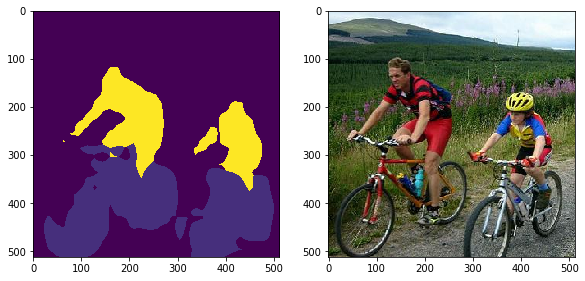

In [154]:
#imperson = preds[0,class2index['person'],:,:]
print(preds.shape)
imclass = np.argmax(preds, axis=3)[0,:,:]
print(imclass.shape)
plt.figure(figsize = (15, 7))
plt.subplot(1,3,2)
plt.imshow( imclass )
plt.subplot(1,3,3)
plt.imshow( np.asarray(im) )